# Mini-project n° 2 – Conditional VAEs

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
import itertools


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


Les Autoencodeurs Variationnels Conditionnels (VAEs Conditionnels) s'appuient, tout comme les VAE standards, sur un modèle : encodeur  - décodeur avec compression des données dans un espace latent intermédiaire.

La principale différence est l'introduction d'entrées conditionnelles qui permettent au modèle de générer des échantillons de données en fonction de conditions ou d'attributs spécifiques (source). L'espace latent est lui même un espace latent conditionnel, la distribution de la variable latente z dépendant de ces attributs.

## Listes des hyperparamètres

Les hyperparamètres de notre modèle sont : 

- batch size = Le nombre d'échantillons sur lesquels le modèle apprend avant de mettre à jour ses paramètres internes (poids du réseau...)
- epochs = Le nombre de fois où l'entièreté du jeu de données est utilisée pour l'apprentissage. Une valeur trop faible peut conduire à du sous-apprentissage et au contraire une valeur trop élevée à du surapprentissage
- latent_dim = La taille de l'espace latent
- learning_rate = Le taux d'apprentissage. Il contrôle la vitesse à laquelle le modèle apprend.
- kl_weights = La liste des poids pour la divergence KL (Kullback-Leibler)
- beta = Ajuste l'importance de la divergence dans la fonction de perte

La fonction de perte utilisée ci-après est définie de la manière suivante :

<div style="text-align: center;">
    Loss = BCE + beta * KLD
</div>
où BCE correspond à la "Binary Cross-Entropy" et KLD est la Divergence KL

Le premier terme est un terme de reconstruction : il mesure à quel point le réseau reconstruit correctement les données d’origine à partir de l’espace latent.
Le second terme est un terme de régularisation : il mesure à quel point la distribution de l'espace latent se rapproche d'une loi normale centrée réduite.

Ainsi, 3 cas sont à distinguer concernant le paramètre beta :

- beta = 1 : On accorde autant d'importance à la reconstruction qu'à la régularisation.
- beta > 1 : On donne davantage de poids à la régularisation. On fait en sorte que la distribution de l'espace latent se rapproche au plus d'une gaussienne centrée réduite. Cependant, cela peut diminuer la capacité de reconstruction du modèle.
- beta < 1 : On donne davantage de poids à la reconstruction. Le modèle apprend ainsi à capturer plus de détails dans l'image. Cependant, cela peut augmenter le risque de surapprentissage.

In [2]:
# Liste des hyperparamètres
batch_size = 128
epochs = 5
latent_dim = 2
learning_rate = 1e-3
kl_weights = [1, 10, 100]
beta = 1

# Autres paramètres
nb_classes=10

nb_classes correspond au nombre de classes pouvant être générées par le modèle, en l'occurence les chiffres de 0 à 9.

## Chargement des données

In [3]:
# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


## Création d'un modèle d'AutoEndodeur Variationnel Conditionnel (Conditionnal VAE)

Le modèle de VAE conditionnel utilisé par la suite se construit de la manière suivante :

- **Un Encodeur** : 
    - Une couche de convolution composée de 32 filtres, un noyau de taille 4, un stride de 2 and un padding de 1.
    - Une couche BatchNorm qui conserve le même nombre de caractérstiques.
    - Une fonction d'activation ReLu.
    - Une couche de convolution composée de 64 filtres, un noyau de taille 4, un stride de 2 and un padding de 1.
    - Une couche BatchNorm qui conserve le même nombre de caractérstiques.
    - Une fonction d'activation ReLu.
    - Une couche de convolution composée de 128 filtres, un noyau de taille 3, un stride de 2 and un padding de 1..
    - Une couche BatchNorm qui conserve le même nombre de caractérstiques.
    - Une fonction d'activation ReLu.

- **Un Espace Latent** :

Il est composé de deux couches parallèles dites "entièrement connectées" (en d'autres termes tous les neurones sont connectés à ceux de la couche précédente, qui est ici la sortie de l'encodeur E(x)).

- La première couche estime un vecteur moyenne µ(x)
- La seconde couche estime un vecteur de log-variance $\log\sigma^2(x)$

Une dernière couche entièrement connectée utilise alors ces informations pour renvoyer la variable latente z selon une distribution gaussienne : $z(x)\sim\mathcal{N}(\mu(x),Diag(\sigma(x)))$ 

- **Un Décodeur.** 
    - Une couche de déconvolution composée de 64 filtres, un noyau de taille 3, un stride de 2 and un padding de 1.
    - Une couche BatchNorm qui conserve le même nombre de caractérstiques
    - Une fonction d'activation ReLu
    - Une couche de déconvolution composée de 32 filtres, un noyau de taille 4, un stride de 2 and un padding de 1.
    - Une couche BatchNorm qui conserve le même nombre de caractérstiques
    - Une fonction d'activation ReLu
    - Une couche de déconvolution composée de 1 filtre, un noyau de taille 4, un stride de 2 and un padding de 1.
    - Une fonction d'activation Sigmoïde

**Au niveau de l'encodeur :**

Pour chacune des couches de convolution :
- Un filtre (ou noyau) est une matrice de poids qui parcourt l’image d’entrée pour extraire des caractéristiques spécifiques (de manière générale comme des contours ou des textures). La sortie de la couche est obtenue à partir d'une convolution entre l'objet en entrée et le filtre. Le paramètre kernel_size désigne la taille de la matrice.
- Un filtre apprend UNE caractéristique de l’image donc, plus il y a de filtres, plus le modèle retient de caractéristiques.
- Le stride indique de combien de pixels le filtre se déplace à chaque étape lorsqu’il parcourt l’image d’entrée (d'abord horizontalement puis verticalement). 
- Le padding consiste à ajouter des pixels autour de l'image pour essayer de préserver l'information sur les bords de l'image. Un padding de 1 signfie que l'on ajoute une rangée de pixel tout autour de l'image

L’augmentation progressive du nombre de filtres dans les couches de convolution permet de capturer des caractéristiques de plus en plus complexes des données d’entrée : les couches proches de l'entrée capturent des motifs de base et au fur et à mesure que l’on avance dans le réseau, on veut que chaque couche représente des détails plus sophistiqués. Avoir plus de filtres permet à chaque couche de détecter des motifs plus variés et spécifiques.

La couche BatchNorm permet de normaliser les sorties d'une couche de réseau lors de l'apprentissage.

**Au niveau du décodeur :**

La fonction d'activation utilisée en sortie est la fonction Sigmoïde. Elle renvoie des valeurs comprises entre 0 et 1 , ce qui est utile puisqu' avec ce réseau on cherche à générer des images en noir et blanc. Les résultats obtenus permettent donc directement d'obtenir des nuances de gris.




**Le vecteur de conditionnement c** :

Donne une information/une étiquette sur les données. Ici c indique la valeur numérique associée à une image du jeu de données (ie le chiffre représenté).
La variable latente z est alors conditionnée par c.

In [4]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=10, num_classes=10):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4 + num_classes, latent_dim) # (128*4*4) est la taille de sortie de la couche précédente
        self.fc_logvar = nn.Linear(128 * 4 * 4 + num_classes, latent_dim) 
        self.fc_decode = nn.Linear(latent_dim + num_classes, 128 * 4 * 4) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x, c):
        x = self.encoder(x)
        x = x.view(-1, 128 * 4 * 4) # "Applatissement" de la sortie après convolution (on restructure les donnes pour que x et c soient de meme taille)
        x = torch.cat((x,c),dim=1) # Concaténation de x et c
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    

    def latent_sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        z = torch.cat((z,c),dim=1)
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.latent_sample(mu, logvar)
        return self.decode(z, c), mu, logvar

## Création de la fonction de perte (loss function)

La formule de la fonction de perte est celle donnée précédemment : 

<div style="text-align: center;">
    Loss = BCE + beta * KLD
</div>

L'objectif est d'avoir un bon compromis entre reconstruction et régularisation.

Pour le terme de reconstruction, on utilise la "Binary Cross-entropy" afin d'accentuer les contrastes (on oblige les pixels à prendre des valeurs très proches de 0 ou de 1 et donc à avoir des zones de l'image très blanches et d'autres très noires).

In [5]:
def loss_function(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') # terme de reconstruction 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # terme de regularisation (on cherche à se rapprocher d'une loi normale)
    return BCE + beta * KLD

## Apprentissage du modèle de VAE conditionnel

In [ ]:
# Initialisation du modèle de VAE model
vae = ConvVAE(latent_dim=latent_dim, num_classes=nb_classes)
vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate) 
# On choisit l'optimizer Adam, couramment utilisé dans l'industrie pour ses performances

# On entraîne le modèle sur chaque epoch
for epoch in range(1, epochs + 1):
    vae.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=nb_classes).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar, beta)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}') # Affiche la fonction de perte

Epoch 1, Training loss: 272.3697
Epoch 2, Training loss: 257.5682
Epoch 3, Training loss: 255.8459
Epoch 4, Training loss: 254.9268
Epoch 5, Training loss: 254.4304


## Génération des images

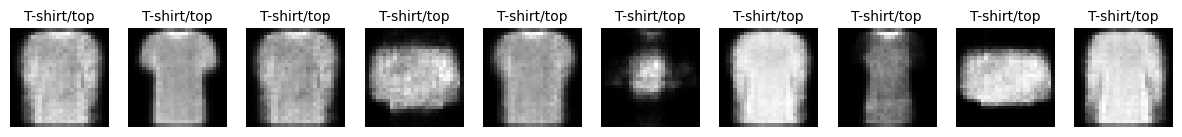

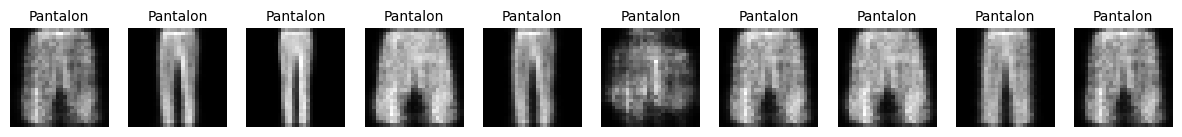

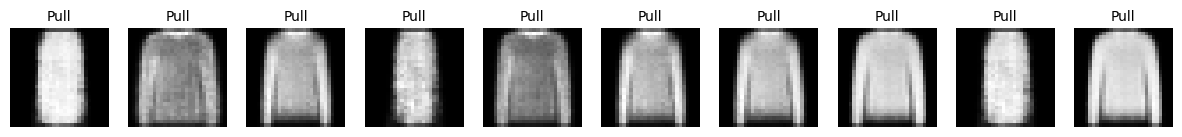

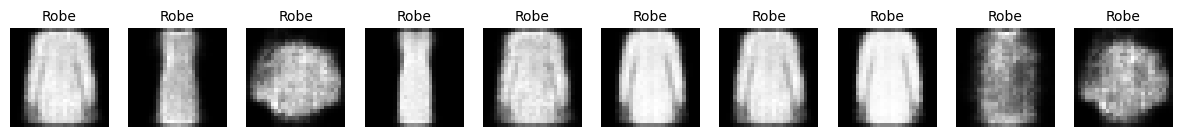

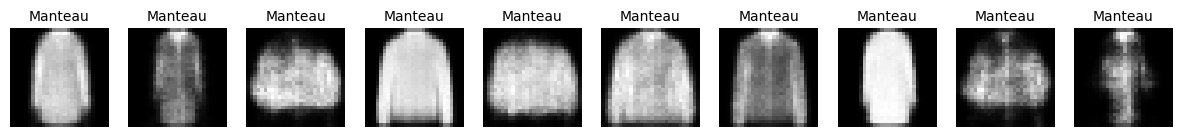

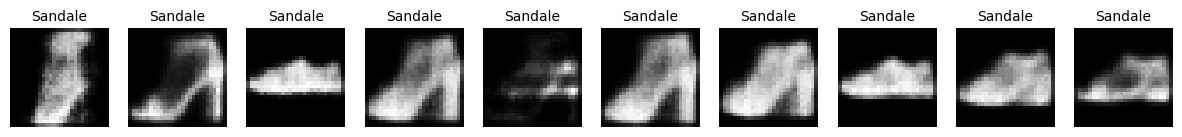

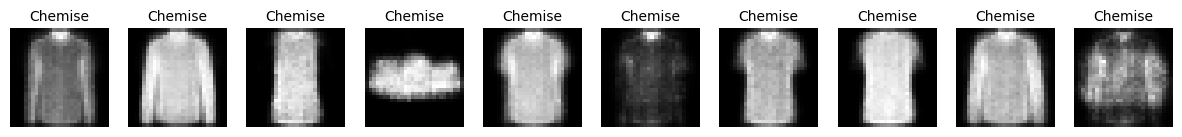

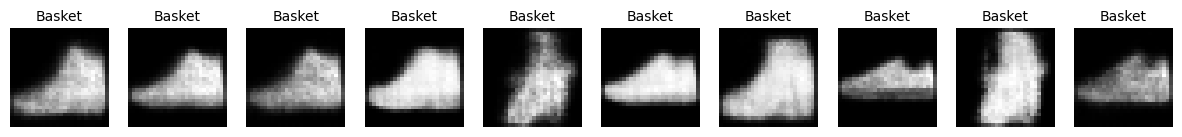

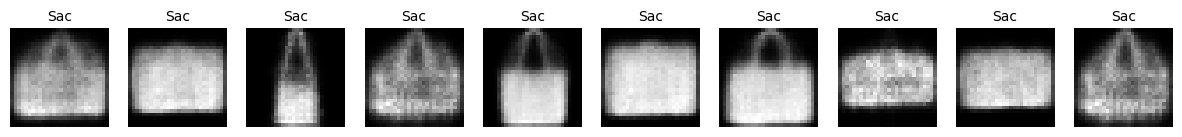

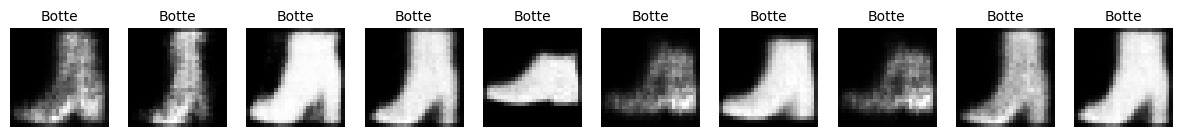

In [15]:
def generate_sample(num_samples=10, objet="robe"):
# digit est la valeur conditionelle c'est-à-dire la classe que l'on veut générer
    vae.eval()
    with torch.no_grad():

        # Échantillonage selon une loi normale
        z = torch.randn(num_samples, latent_dim).to(device)

        # On ajoute la condition ie la valeur que l'on veut générer
        condition = torch.zeros(num_samples,10, dtype=int).to(device)
        condition[:, objet] = 1 # indique que c'est la valeur digit que l'on cherche à générer

        # On génère l'image
        samples = vae.decode(z, condition)
        samples = samples.cpu().view(num_samples, 1, 28, 28)

        class_names = [
            "T-shirt/top", "Pantalon", "Pull", "Robe", "Manteau",
            "Sandale", "Chemise", "Basket", "Sac", "Botte"
        ]

        fig, ax = plt.subplots(1, num_samples, figsize=(15, 2))
        for i in range(num_samples):
            ax[i].imshow(samples[i].squeeze(0), cmap='gray')
            ax[i].axis('off')
            ax[i].set_title(class_names[objet], fontsize=10)
        plt.show()


for classe in range(nb_classes):
    generate_sample(num_samples=10, objet=classe) # on génère 10 échantillons pour chaque classe

## Optimisation des paramètres

L'objectif de cette section est de tester différentes combinaisons d'hyperparamètres afin de déterminer celle qui est la plus optimale. Pour cela, pour chaque combinaison on calcule la valeur de la fonction de perte obtenue à la fin de l'apprentissage. On regarde alors quelle combinaison nous permet d'avoir une valeur minimale. Nos images seront ensuite générées avec cette combinaison d'hyperparamètres.

Afin de limiter les temps de calcul, 3 valeurs ont été testées pour chaque hyperparamètre que l'on a voulu optimiser.

In [ ]:
# Liste des hyperparamètres
batch_size_list = [32, 64, 128]
epochs_list = [5, 10, 50]
latent_dim_list = [2, 10, 64]
beta_list = [0.5, 1, 2]

def Optimisation(batch_size_list, epochs_list, latent_dim_list, beta_list) :
    combinations = list(itertools.product(batch_size_list, epochs_list, latent_dim_list, beta_list))
    loss_list = []
    param_list = []

    for batch_size_opt, epochs_opt, latent_dim_opt, beta_opt in  combinations:
        train_loader_opt = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_opt, shuffle=True)
        test_loader_opt = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size_opt, shuffle=False)

        # Initialisation du modèle de VAE model
        vae = ConvVAE(latent_dim=latent_dim_opt, num_classes=nb_classes)
        vae.to(device)
        optimizer = optim.Adam(vae.parameters(), lr=learning_rate) 
        # On choisit l'optimizer Adam, couramment utilisé dans l'industrie pour ses performances

        # On entraîne le modèle sur chaque epoch
        for epoch in range(1, epochs_opt + 1):
            vae.train()
            running_loss = 0.0
            for batch_idx, (data, labels) in enumerate(train_loader_opt):
                data = data.to(device)
                labels = F.one_hot(labels, num_classes=nb_classes).to(device)
                optimizer.zero_grad()
                recon_batch, mu, logvar = vae(data, labels)
                loss = loss_function(recon_batch, data, mu, logvar, beta_opt)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            
            epoch_loss = running_loss / len(train_loader_opt.dataset)
        loss_list.append(epoch_loss)
        param_list.append([batch_size_opt, epochs_opt, latent_dim_opt, beta_opt])

    print(f"Valeur minimale de la fonction de perte : {min(loss_list)}, pour les paramètres suivants :")
    print(f"batch_size_opt : {param_list[loss_list.index(min(loss_list))][0]}")
    print(f"epochs_opt : {param_list[loss_list.index(min(loss_list))][1]}")
    print(f"latent_dim_opt : {param_list[loss_list.index(min(loss_list))][2]}")
    print(f"beta_opt : {param_list[loss_list.index(min(loss_list))][3]}")


In [24]:
Optimisation(batch_size_list, epochs_list, latent_dim_list, beta_list)

Valeur minimale de la fonction de perte : 224.15730145670574, pour les paramètres suivants :
batch_size_opt : 64
epochs_opt : 50
latent_dim_opt : 64
beta_opt : 0.5


On va ensuite chercher à voir l'influence de chaque paramètre sur les valeurs de la fonction de perte. Cette fois-ci, pour chaque graphe obtenu, 3 des 4 paramètres sont fixés tandis que le troisème varie.

In [6]:
# Liste des hyperparamètres
batch_size_list = [32, 64, 128]
epochs_list = [5, 10, 50]
latent_dim_list = [2, 10, 64]
beta_list = [0.5, 1, 2]

def apprentissage(batch_size_opt, epochs_opt, latent_dim_opt, beta_opt):
    loss_list = []
    param_list = []

    train_loader_opt = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_opt, shuffle=True)

    # Initialisation du modèle de VAE model
    vae = ConvVAE(latent_dim=latent_dim_opt, num_classes=nb_classes)
    vae.to(device)
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate) 
    # On choisit l'optimizer Adam, couramment utilisé dans l'industrie pour ses performances

    # On entraîne le modèle sur chaque epoch
    for epoch in range(1, epochs_opt + 1):
        vae.train()
        running_loss = 0.0
        for batch_idx, (data, labels) in enumerate(train_loader_opt):
            data = data.to(device)
            labels = F.one_hot(labels, num_classes=nb_classes).to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data, labels)
            loss = loss_function(recon_batch, data, mu, logvar, beta_opt)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader_opt.dataset)
    loss_list.append(epoch_loss)
    param_list.append([batch_size_opt, epochs_opt, latent_dim_opt, beta_opt])
    return(loss_list, param_list)




def Optimisation_graphe(batch_size_list, epochs_list, latent_dim_list, beta_list) :
    xb = []
    lossb = []
    xe = []
    losse = []
    xl = []
    lossl = []
    xbe = []
    lossbe = []
    
    for batch_opt in batch_size_list :
        torch.cuda.empty_cache()
        loss_batch, param_batch = apprentissage(batch_opt, epochs, latent_dim, beta)
        xb.append(batch_opt)
        lossb.append(loss_batch)

    plt.plot(xb, lossb, label='Fonction de perte pour des batchs différents')
    plt.xlabel('Batch')
    plt.ylabel('Fonction de perte')
    plt.legend()
    plt.show()

    for epochs_opt in epochs_list :
        torch.cuda.empty_cache()
        loss_epoch, param_epoch = apprentissage(batch_size, epochs_opt, latent_dim, beta)
        xe.append(epochs_opt)
        losse.append(loss_epoch)

    plt.plot(xe, losse, label='Fonction de perte pour des epochs différents')
    plt.xlabel('Epochs')
    plt.ylabel('Fonction de perte')
    plt.legend()
    plt.show()

    for latent_dim_opt in latent_dim_list :
        torch.cuda.empty_cache()
        loss_latent, param_latent = apprentissage(batch_size, epochs, latent_dim_opt, beta)
        xl.append(latent_dim_opt)
        lossl.append(loss_latent)

    plt.plot(xl, lossl, label='Fonction de perte pour des espaces latents différents')
    plt.xlabel('Espaces Latents')
    plt.ylabel('Fonction de perte')
    plt.legend()
    plt.show()

    for beta_opt in beta_list :
        torch.cuda.empty_cache()
        loss_beta, param_beta = apprentissage(batch_size, epochs, latent_dim, beta_opt)
        xbe.append(beta_opt)
        lossbe.append(loss_beta)

    plt.plot(xbe, lossbe, label='Fonction de perte pour des beta différents')
    plt.xlabel('Beta')
    plt.ylabel('Fonction de perte')
    plt.legend()
    plt.show()
    

On choisit ici de prendre pour paramètres fixés les paramètres optimaux obtenus précédemment.

In [20]:
# Liste des hyperparamètres optimaux
batch_size = 64
epochs = 50
latent_dim = 64
beta = 0.5

Optimisation_graphe(batch_size_list, epochs_list, latent_dim_list, beta_list)

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Visualisation de l'espace latent

In [16]:
# On utilise la même fonction de perte mais cette fois-ci on renvoie séparément la valeur de la loss, de la cross-entropy et de la divergence
def loss_function_sep(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD


Training VAE with KL Weight = 1
Epoch 1: Average Loss: 273.7344, BCE: 268.7196, KLD: 5.0148
Epoch 2: Average Loss: 257.7618, BCE: 252.6958, KLD: 5.0660
Epoch 3: Average Loss: 256.0321, BCE: 250.9931, KLD: 5.0390
Epoch 4: Average Loss: 255.1945, BCE: 250.1623, KLD: 5.0322
Epoch 5: Average Loss: 254.4616, BCE: 249.4747, KLD: 4.9869


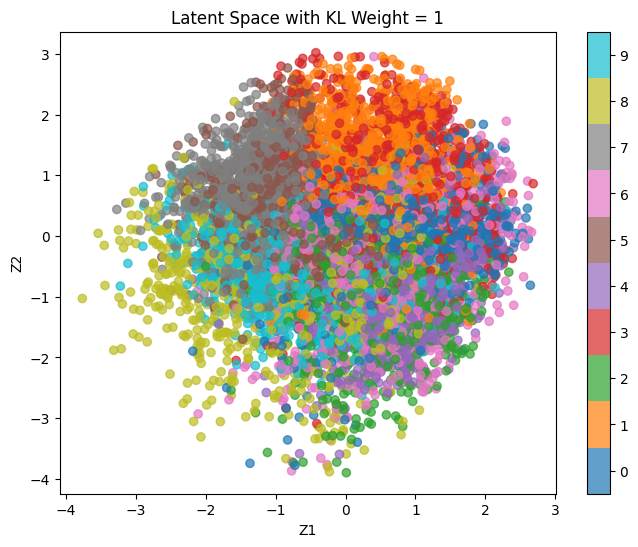


Training VAE with KL Weight = 10
Epoch 1: Average Loss: 298.2971, BCE: 283.4049, KLD: 1.4892
Epoch 2: Average Loss: 283.3908, BCE: 266.7020, KLD: 1.6689
Epoch 3: Average Loss: 281.4602, BCE: 264.3666, KLD: 1.7094
Epoch 4: Average Loss: 280.3240, BCE: 263.1294, KLD: 1.7195
Epoch 5: Average Loss: 279.5064, BCE: 262.2245, KLD: 1.7282


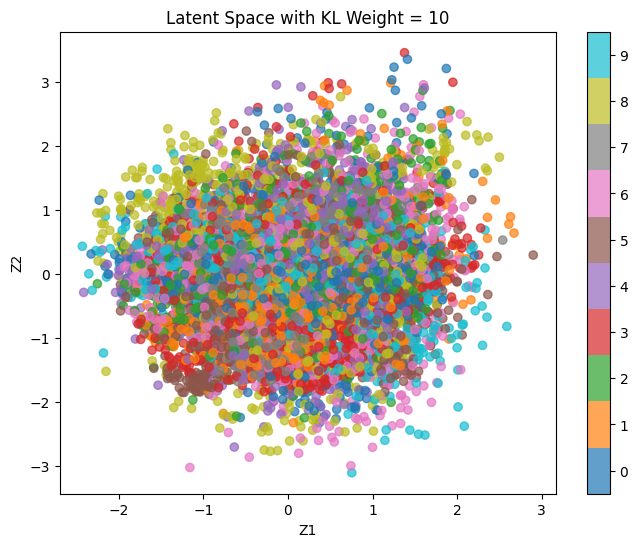


Training VAE with KL Weight = 100
Epoch 1: Average Loss: 323.6142, BCE: 321.2917, KLD: 0.0232
Epoch 2: Average Loss: 308.1290, BCE: 307.9735, KLD: 0.0016
Epoch 3: Average Loss: 307.8093, BCE: 307.6850, KLD: 0.0012
Epoch 4: Average Loss: 307.6901, BCE: 307.5945, KLD: 0.0010
Epoch 5: Average Loss: 307.6491, BCE: 307.5610, KLD: 0.0009


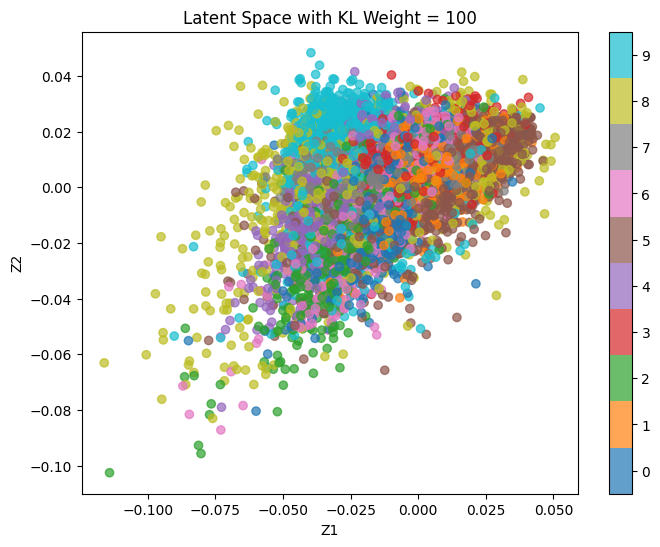

In [ ]:
# Apprentissage du modèle en fonction de la divergence
def train_and_plot(kl_weight):
    model = ConvVAE(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    
    for epoch in range(epochs):
        epoch_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = F.one_hot(labels, num_classes=nb_classes).to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar = model(data, labels)
            loss, bce, kld = loss_function_sep(x_recon, data, mu, logvar, kl_weight)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()
        
        average_loss = epoch_loss / len(train_loader.dataset)
        average_bce = bce_loss / len(train_loader.dataset)
        average_kld = kld_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f}, BCE: {average_bce:.4f}, KLD: {average_kld:.4f}')
    
    # Visualisation de l'espace latent
    plot_latent_space(model, kl_weight)


def plot_latent_space(model, kl_weight):
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
        data, labels = next(iter(test_loader))
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=nb_classes).to(device)

        mu, logvar = model.encode(data, labels)
        z = mu  # Pour la visualisation on utilise la moyenne
        z = z.cpu().numpy()
        labels = labels.cpu().numpy()

        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=np.argmax(labels, axis=1), cmap='tab10', alpha=0.7)  # On utilise np.argmax pour obtenir les classes
        plt.colorbar(scatter, ticks=range(10))
        plt.clim(-0.5, 9.5)
        plt.title(f'Latent Space with KL Weight = {kl_weight}')
        plt.xlabel('Z1')
        plt.ylabel('Z2')
        plt.show()


# Visualisation de l'espace latent en fonction de la valeur de la divergence
for kl_weight in kl_weights:
    print(f'\nTraining VAE with KL Weight = {kl_weight}')
    train_and_plot(kl_weight)